In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import numpy as np
import pylab as plt
import scipy.stats

## Simulator definition

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds_z = None, bimodal = False):
        super().__init__()
        self.z_sampler = swyft.RectBoundSampler(
            [stats.uniform(-1, 2),
             stats.uniform(-1, 2),
            ],
            bounds = bounds_z
        )
        self.bimodal = bimodal
        
    def f(self, z):
        if self.bimodal:
            if z[0]< 0:
                z = np.array([z[0]+0.5, z[1]-0.5])
            else:
                z = np.array([z[0]-0.5, -z[1]-0.5])
        z = 10*np.array([z[0], 10*z[1]+100*z[0]**2])
        return z

    def build(self, graph):
        z = graph.node("z", self.z_sampler)
        x = graph.node("x", lambda z: self.f(z)+np.random.randn(2), z)
        l = graph.node("l", lambda z: -stats.norm.logpdf(self.f(z)).sum(), z)  # return -ln p(x=0|z) for cross-checks

## Define round simulator

In [14]:
sim = Simulator(bounds_z = None, bimodal = False)

### Generate training data

In [15]:
samples = sim.sample(30_000)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 64)

  0%|          | 0/30000 [00:00<?, ?it/s]

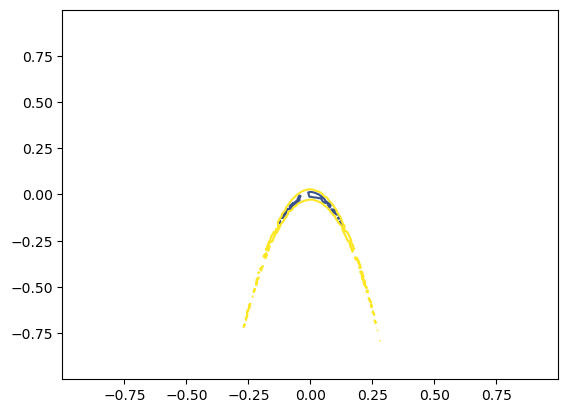

In [16]:
plt.tricontour(samples['z'][:,0], samples['z'][:,1], samples['l']-samples['l'].min(), levels = [0, 1, 4])

## Define inference network

In [11]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 2, num_params = 2, varnames = 'z',
                                                       dropout = 0.2, hidden_features = 128)
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 2, marginals = ((0, 1),), varnames = 'z',
                                                       dropout = 0.2, hidden_features = 128)

    def forward(self, A, B):
        return self.logratios1(A['x'], B['z']), self.logratios2(A['x'], B['z'])

network = Network()

In [12]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [13]:
trainer.fit(network, dm)


  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 135 K 
1 | logratios2 | LogRatioEstimator_Ndim | 67.8 K
------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
1.626     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [272]:
prior_samples = sim.sample(10_000, targets = ['z'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [273]:
obs = swyft.Sample(x = np.array([0., 0.]))
predictions = trainer.infer(network, obs, prior_samples)

Predicting: 22it [00:00, ?it/s]

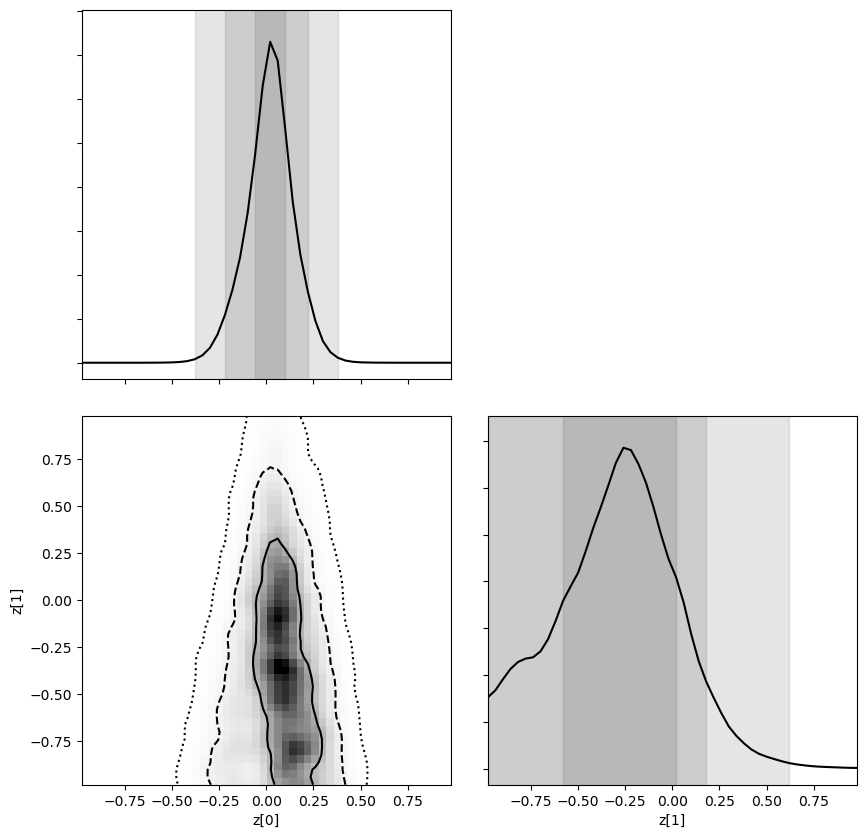

In [276]:
swyft.corner(predictions, ["z[0]", "z[1]"], bins = 50, smooth = 1);